In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## Data Pre-Processing

In [5]:
df = pd.read_csv("ai4i2020.csv") #read data
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [6]:
#Drop UDI & Product ID columns since they do not contain relevant information for the model to learn
df = df.drop(['UDI','Product ID'], axis=1)

#Divide Dataframe into categorical and numerical columns
df_cat = df[['Type']]
df_num = df.drop(['Type','Machine failure','TWF','HDF','PWF','OSF','RNF'], axis=1)

#Scaling numerical data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_num = scaler.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                                         'Torque [Nm]','Tool wear [min]'])

#One hot encode categorical labels
cat = pd.get_dummies(df_cat[['Type']], dtype=float)
df_cat = pd.DataFrame(cat)

#Concate encoded categorical data and scaled numerical data
X = pd.concat([df_cat,df_num],axis=1)
y = df[['Machine failure']]
del df #delete df for memmory

In [7]:
#Check X and y data
X.head(5)

,Type_H,Type_L,Type_M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0.0,0.0,1.0,0.304348,0.358025,0.222934,0.535714,0.000000
1,0.0,1.0,0.0,0.315217,0.370370,0.139697,0.583791,0.011858
2,0.0,1.0,0.0,0.304348,0.345679,0.192084,0.626374,0.019763
3,0.0,1.0,0.0,0.315217,0.358025,0.154249,0.490385,0.027668
4,0.0,1.0,0.0,0.315217,0.370370,0.139697,0.497253,0.035573


In [5]:
#Check X and y data
y.value_counts()
#here we can see that we have a heavily unbalanced data set

Machine failure
0                  9661
1                   339
dtype: int64

In [6]:
#split training and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101, stratify=y)



In [15]:
y_train.value_counts()

Machine failure
0                  7729
1                   271
dtype: int64

In [16]:
y_test.value_counts()

Machine failure
0                  1932
1                    68
dtype: int64

In [19]:
len(y_train)

8000

### Training and testing an initial version of the model

In [7]:
from sklearn.svm import SVC #import SVC model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


model_0 = SVC() #create default model
model_0.fit(X_train, y_train.values.ravel()) #train model
y_pred = model_0.predict(X_test)#make predictions

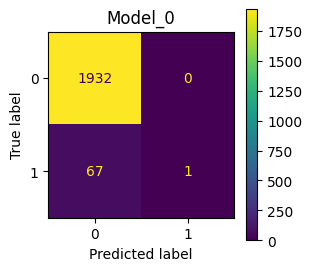

In [8]:
#make confusion matrix
cm_0 = confusion_matrix(y_test, y_pred, labels=model_0.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_0, display_labels=model_0.classes_)
fig, ax = plt.subplots(figsize=(3, 3))
plt.title('Model_0')#can specify fontsize with fontsize=float
disp.plot(ax=ax)

In [9]:
# Get accuracy, precision, recall and f1 score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#Print metrics for model_0
#(y_true, y_pred)
print("Model_0 accuracy : ",accuracy_score(y_test,y_pred))
print("Model_0 precision :",precision_score(y_test,y_pred))
print("Model_0 recall :   ",recall_score(y_test,y_pred))
print("Model_0 f1_score : ",f1_score(y_test,y_pred))


#We have a high accuracy but this does not mean this model performs well since the data set is highly unbalanced and
#Probably this model is really good at predicting which machines won't fail but is very bad predicting which machines 
#will fail (see recall score), we actually want to trade some precision for a better performance in recall 
#since predicting which machines will fail is more important for this problem and also we would rather predict that a machine 
#will fail and have that machine not failing than the other way around

Model_0 accuracy :  0.9665
Model_0 precision : 1.0
Model_0 recall :    0.014705882352941176
Model_0 f1_score :  0.028985507246376812


### GridSearch

In [11]:
#Using GridSearch to find the parameters that will have better performance for this model
# Define the parameter grid for GridSearchCV
param_grid = {'C': [0.01, 0.1, 10], 
              'kernel': ['linear','sigmoid', 'poly', 'rbf'], 
              'degree': [3,4], 'gamma':  [0.01, 0.1, 10]}

#Create an SVM classifier
svm_classifier = SVC()

# Create a GridSearchCV object
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, cv=3, scoring='recall')
grid_search.fit(X_train, y_train.values.ravel())# fit the grid search object to the data

print("best params :",grid_search.best_params_)
print("best estimator :",grid_search.best_estimator_)

#estimate time 25 min

best params : {'C': 10, 'degree': 4, 'gamma': 10, 'kernel': 'poly'}
best estimator : SVC(C=10, degree=4, gamma=10, kernel='poly')


### Hyperparameter Tunning

In [10]:
# let's see how the optimized parameters do
model_1 = SVC(C=10, degree=4, gamma=10, kernel='poly') #create default model

In [11]:
model_1.fit(X_train, y_train.values.ravel()) #train model

SVC(C=10, degree=4, gamma=10, kernel='poly')

In [12]:
y_pred_1 = model_1.predict(X_test)#make predictions

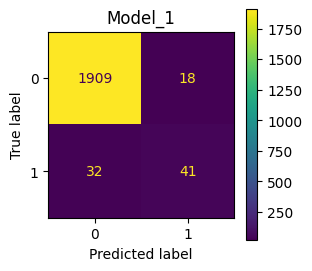

In [13]:
#make confusion matrix
cm_1 = confusion_matrix(y_test, y_pred_1, labels=model_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=model_1.classes_)
fig, ax = plt.subplots(figsize=(3, 3))
plt.title('Model_1')#can specify fontsize with fontsize=float
disp.plot(ax=ax)

In [14]:
#Print metrics for model_1
#(y_true, y_pred)
print("Model_1 accuracy : ",accuracy_score(y_test,y_pred_1))
print("Model_1 precision :",precision_score(y_test,y_pred_1))
print("Model_1 recall :   ",recall_score(y_test,y_pred_1))
print("Model_1 f1_score : ",f1_score(y_test,y_pred_1))

Model_1 accuracy :  0.975
Model_1 precision : 0.6949152542372882
Model_1 recall :    0.5616438356164384
Model_1 f1_score :  0.6212121212121213


In [10]:
# let's try to play a little bit with the hyperparameters to see with we can increase the recall without sacrificing too much
# Precision
model_2 = SVC(C=20, degree=4, gamma=20, kernel='poly') #create default model
model_2.fit(X_train, y_train.values.ravel()) #train model
y_pred_2 = model_2.predict(X_test)#make predictions

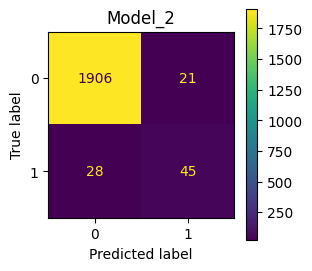

In [11]:
#make confusion matrix
cm_2 = confusion_matrix(y_test, y_pred_2, labels=model_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=model_2.classes_)
fig, ax = plt.subplots(figsize=(3, 3))
plt.title('Model_2')#can specify fontsize with fontsize=float
disp.plot(ax=ax)

In [12]:
#Print metrics for model_2
#(y_true, y_pred)
print("Model_2 accuracy : ",accuracy_score(y_test,y_pred_2))
print("Model_2 precision :",precision_score(y_test,y_pred_2))
print("Model_2 recall :   ",recall_score(y_test,y_pred_2))
print("Model_2 f1_score : ",f1_score(y_test,y_pred_2))


#From tunning hyperparameters C & Gamma we see that we obtain a better recall so let's try to train one more model
#And see how much more we can improve the recall for this data set using SVM's

Model_2 accuracy :  0.9755
Model_2 precision : 0.6818181818181818
Model_2 recall :    0.6164383561643836
Model_2 f1_score :  0.6474820143884891


In [13]:
#Let's also measure how much time does the PC take to train this model
model_3 = SVC(C=80, degree=4, gamma=80, kernel='poly') #create default model
start = time.time()
model_3.fit(X_train, y_train.values.ravel()) #train model
end = time.time()
y_pred_3 = model_3.predict(X_test)#make predictions

In [15]:
print("Minutes for training model_3: ",(end - start)/60)

Minutes for training model_3:  43.957631778717044


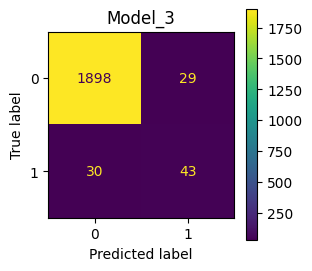

In [16]:
#make confusion matrix
cm_3 = confusion_matrix(y_test, y_pred_3, labels=model_3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=model_3.classes_)
fig, ax = plt.subplots(figsize=(3, 3))
plt.title('Model_3')#can specify fontsize with fontsize=float
disp.plot(ax=ax)

In [17]:
#Print metrics for model_3
#(y_true, y_pred)
print("Model_3 accuracy : ",accuracy_score(y_test,y_pred_3))
print("Model_3 precision :",precision_score(y_test,y_pred_3))
print("Model_3 recall :   ",recall_score(y_test,y_pred_3))
print("Model_3 f1_score : ",f1_score(y_test,y_pred_3))


#Now we can see that rather than improving recall it decreased so let's make a final model with all the info we have now

Model_3 accuracy :  0.9705
Model_3 precision : 0.5972222222222222
Model_3 recall :    0.589041095890411
Model_3 f1_score :  0.593103448275862


In [13]:
model_4 = SVC(C=40, degree=4, gamma=40, kernel='poly') #create default model
start = time.time()
model_4.fit(X_train, y_train.values.ravel()) #train model
end = time.time()
y_pred_4 = model_4.predict(X_test)#make predictions

print("Minutes for training model_4: ",(end - start)/60)

Minutes for training model_4:  27.653026044368744


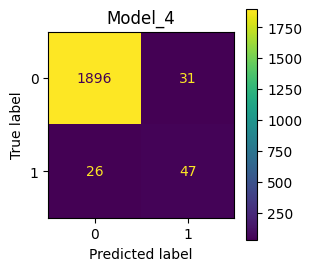

In [14]:
#make confusion matrix
cm_4 = confusion_matrix(y_test, y_pred_4, labels=model_4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_4, display_labels=model_4.classes_)
fig, ax = plt.subplots(figsize=(3, 3))
plt.title('Model_4')#can specify fontsize with fontsize=float
disp.plot(ax=ax)

In [15]:
#Print metrics for model_4
#(y_true, y_pred)
print("Model_4 accuracy : ",accuracy_score(y_test,y_pred_4))
print("Model_4 precision :",precision_score(y_test,y_pred_4))
print("Model_4 recall :   ",recall_score(y_test,y_pred_4))
print("Model_4 f1_score : ",f1_score(y_test,y_pred_4))

Model_4 accuracy :  0.9715
Model_4 precision : 0.6025641025641025
Model_4 recall :    0.6438356164383562
Model_4 f1_score :  0.6225165562913907


In [8]:
model_5 = SVC(C=30, degree=4, gamma=30, kernel='poly') #create default model
start = time.time()
model_5.fit(X_train, y_train.values.ravel()) #train model
end = time.time()
y_pred_5 = model_5.predict(X_test)#make predictions

print("Minutes for training model_5: ",(end - start)/60)

Minutes for training model_5:  50.89790127674738


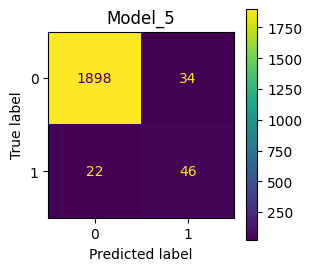

In [12]:
#make confusion matrix
cm_5 = confusion_matrix(y_test, y_pred_5, labels=model_5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_5, display_labels=model_5.classes_)
fig, ax = plt.subplots(figsize=(3, 3))
plt.title('Model_5')#can specify fontsize with fontsize=float
disp.plot(ax=ax)

In [11]:
#Print metrics for model_4
#(y_true, y_pred)
print("Model_5 accuracy : ",accuracy_score(y_test,y_pred_5))
print("Model_5 precision :",precision_score(y_test,y_pred_5))
print("Model_5 recall :   ",recall_score(y_test,y_pred_5))
print("Model_5 f1_score : ",f1_score(y_test,y_pred_5))

Model_5 accuracy :  0.972
Model_5 precision : 0.575
Model_5 recall :    0.6764705882352942
Model_5 f1_score :  0.6216216216216216


In [13]:
from joblib import dump, load #Save model
dump(model_5, 'svm_5.joblib')

['svm_5.joblib']

In [12]:
#According to several correlation tests the top 5 features in the data set are:
#best features are:
#                    Feature  Total
#1              Torque [Nm]      6
#2      Air temperature [K]      5
#3          Tool wear [min]      4
#4   Rotational speed [rpm]      4
#5  Process temperature [K]      4

#Let's try training our best model using only this features
X_BestFeat = X.loc[:,['Torque [Nm]', 'Air temperature [K]', 
                    'Tool wear [min]', 'Rotational speed [rpm]', 'Process temperature [K]']]

X_BestFeat.head(5)

,Torque [Nm],Air temperature [K],Tool wear [min],Rotational speed [rpm],Process temperature [K]
0,0.535714,0.304348,0.000000,0.222934,0.358025
1,0.583791,0.315217,0.011858,0.139697,0.370370
2,0.626374,0.304348,0.019763,0.192084,0.345679
3,0.490385,0.315217,0.027668,0.154249,0.358025
4,0.497253,0.315217,0.035573,0.139697,0.370370


In [13]:
#Now let's train the model again
from sklearn.model_selection import train_test_split #Train/Test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101, stratify=y)

model_5_1 = SVC(C=30, degree=4, gamma=30, kernel='poly') #create default model
start = time.time()
model_5_1.fit(X_train, y_train.values.ravel()) #train model
end = time.time()
y_pred_5_1 = model_5_1.predict(X_test)#make predictions

print("Minutes for training model_5: ",(end - start)/60)

Minutes for training model_5:  58.97205685774485


In [14]:
#Print metrics for model_4
#(y_true, y_pred)
print("Model_5_1 accuracy : ",accuracy_score(y_test,y_pred_5_1))
print("Model_5_1 precision :",precision_score(y_test,y_pred_5_1))
print("Model_5_1 recall :   ",recall_score(y_test,y_pred_5_1))
print("Model_5_1 f1_score : ",f1_score(y_test,y_pred_5_1))

Model_5_1 accuracy :  0.972
Model_5_1 precision : 0.575
Model_5_1 recall :    0.6764705882352942
Model_5_1 f1_score :  0.6216216216216216
